# Remove mismatched barcodes & apply sample presence filter to generate table of reads across all bulk RNA samples for DESeq2

In [1]:
from datetime import date
print('created 2024-04-24')
print("last updated", date.today())

created 2024-04-24
last updated 2024-06-04


In [2]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 150

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'

In [3]:
# load in barcode-to-intron dictionary from round 2 (bottlenecked)
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters.pkl', 'rb') as f:
    b2i_06 = pickle.load(f)

# load in list of barcodes deemed trustworthy by mismatch analysis
with open(outpath+'pkls/06_4_barcodes_with_less_than_10_percent_reads_mismatched_v3_min3readclusters.pkl', 'rb') as f:
    bcs_to_keep = pickle.load(f)

# manually add back intronless, UbC spike-ins
intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']
UbC_bc = 'ATACCATAACTACCCACT'
for b in intronless_barcodes+[UbC_bc]:
    bcs_to_keep.append((0,b))

# final b2i contains trustworthy barcodes only
b2i = {b:b2i_06[b] for (mismatch_rate, b) in bcs_to_keep}

with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'wb') as f:
    pickle.dump(b2i, f)

In [4]:
# load in read count data

with open(outpath+'data/reads/RIL12_bulk_b2i06_b2r.pkl', 'rb') as f:
    RIL12 = pickle.load(f)

In [5]:
# function to count dTomato and GFP reads per barcode
def gene_counts_for_bc(gene, b, s, RIL):
    if gene == 'GFP':
        idx = 0
    if gene == 'unspliced':
        idx = 1
    if gene == 'dTom':
        idx = 2
    if b in RIL:
        return RIL[b][s][idx]
    else:
        return 0

In [6]:
# build dataframe of reads from all samples
# using all barcodes OR only barcodes deemed as trustworthy 

# set up sample structures
genes = ['GFP','dTom','unspliced']
num_reps = 10
samples = np.arange(num_reps)+1
reps = [str(x) for x in samples]
num_reps_per_run = 5

# set up empty dicts that will become dataframes
all_bcs = list(b2i_06.keys())
good_bcs = list(b2i.keys())
trustworthy_mask = np.array([b in good_bcs for b in all_bcs])
RIL_all = {b:{f'{gene}_{rep}':-1 for gene in genes for rep in reps} for b in all_bcs}

In [7]:
for i,b in enumerate(all_bcs):
    gene_counts = {}
    for g in genes:
        gene_counts[g] = [gene_counts_for_bc(g, b, s, RIL12) for s in samples]
    RIL_all[b] = gene_counts['GFP'] + gene_counts['dTom'] + gene_counts['unspliced'] 

RIL_all_df = pd.DataFrame.from_dict(RIL_all).T
RIL_all_df.columns = [f'{gene}_{rep}' for gene in genes for rep in reps]
RIL_all_df_nonzero = RIL_all_df[np.sum(RIL_all_df.iloc[:,:num_reps], axis=1)!=0]

RIL_good_df = RIL_all_df[trustworthy_mask]
RIL_good_df_nonzero = RIL_good_df[np.sum(RIL_good_df.iloc[:,:num_reps], axis=1)!=0]

In [8]:
np.sum(RIL_good_df).sum()

/Users/emmakowal/miniconda3/envs/random_IME_screens_meta_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


125109190

In [9]:
GFP_counts = RIL_all_df_nonzero.values[:,:num_reps]
dTom_counts = RIL_all_df_nonzero.values[:,num_reps:num_reps*2]
unspliced_counts = RIL_all_df_nonzero.values[:,num_reps*2:num_reps*3]
IME_scores = np.log2((1+GFP_counts+unspliced_counts)/(1+dTom_counts))
readcounts = np.log10(GFP_counts+dTom_counts+unspliced_counts)

GFP_counts_g = RIL_good_df_nonzero.values[:,:num_reps]
dTom_counts_g = RIL_good_df_nonzero.values[:,num_reps:num_reps*2]
unspliced_counts_g = RIL_good_df_nonzero.values[:,num_reps*2:num_reps*3]
IME_scores_g = np.log2((1+GFP_counts_g+unspliced_counts_g)/(1+dTom_counts_g))
readcounts_g = np.log10(GFP_counts_g+dTom_counts_g+unspliced_counts_g)

bcs = np.array(RIL_good_df_nonzero.index)
intless_mask = [b in intronless_barcodes for b in bcs]
pos_ctrl_mask = [b==UbC_bc for b in bcs]

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82683/1291195209.py:5: RuntimeWarning: divide by zero encountered in log10
  readcounts = np.log10(GFP_counts+dTom_counts+unspliced_counts)
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_82683/1291195209.py:11: RuntimeWarning: divide by zero encountered in log10
  readcounts_g = np.log10(GFP_counts_g+dTom_counts_g+unspliced_counts_g)


In [10]:
# from unfiltered unspliced read analysis:
unspl_read_count = 1144849
1-unspl_read_count/np.sum(GFP_counts)

0.9816171672380816

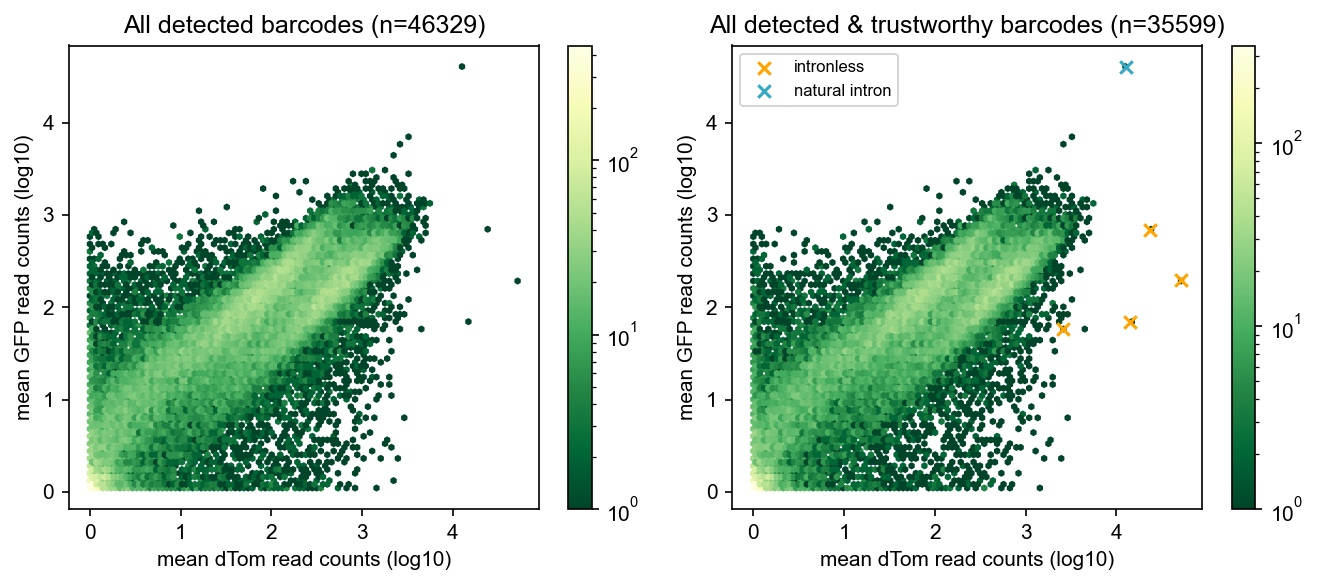

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

hb1=ax1.hexbin(np.log10(1+dTom_counts.mean(1)),
           np.log10(1+GFP_counts.mean(1)), cmap='YlGn_r',
           bins='log')
ax1.set_title(f'All detected barcodes (n={RIL_all_df_nonzero.shape[0]})')
ax1.set_xlabel('mean dTom read counts (log10)')
ax1.set_ylabel('mean GFP read counts (log10)')
cb1 = fig.colorbar(hb1)

hb2=ax2.hexbin(np.log10(1+dTom_counts_g.mean(1)),
           np.log10(1+GFP_counts_g.mean(1)), cmap='YlGn_r',
           bins='log')
ax2.set_title(f'All detected & trustworthy barcodes (n={RIL_good_df_nonzero.shape[0]})')
ax2.set_xlabel('mean dTom read counts (log10)')
ax2.set_ylabel('mean GFP read counts (log10)')

for msk, col, name in [(intless_mask, 'orange', 'intronless'), (pos_ctrl_mask, nicecolors(3), 'natural intron')]:                
    ax2.scatter(np.log10(1+dTom_counts_g.mean(1))[msk],
                np.log10(1+GFP_counts_g.mean(1))[msk],
               marker='x', color=col, label=name)
ax2.legend(loc=2, fontsize=8)

cb2 = fig.colorbar(hb2)

plt.tight_layout()
plt.show()

In [12]:
print(f'total # barcodes in library: {RIL_all_df.shape[0]}')
print(f'total # barcodes actually detected: {RIL_all_df_nonzero.shape[0]}')
print(f'# of "trustworthy" barcodes (<10% mismatch rate): {RIL_good_df.shape[0]}')
print(f'# trustworthy barcodes detected: {RIL_good_df_nonzero.shape[0]}')

total # barcodes in library: 49741
total # barcodes actually detected: 46329
# of "trustworthy" barcodes (<10% mismatch rate): 38163
# trustworthy barcodes detected: 35599


In [13]:
with open(outpath+'pkls/integrated_GFP_dTom_counts_with_unspliced.pkl', 'wb') as f:
    pickle.dump(RIL_good_df_nonzero, f)

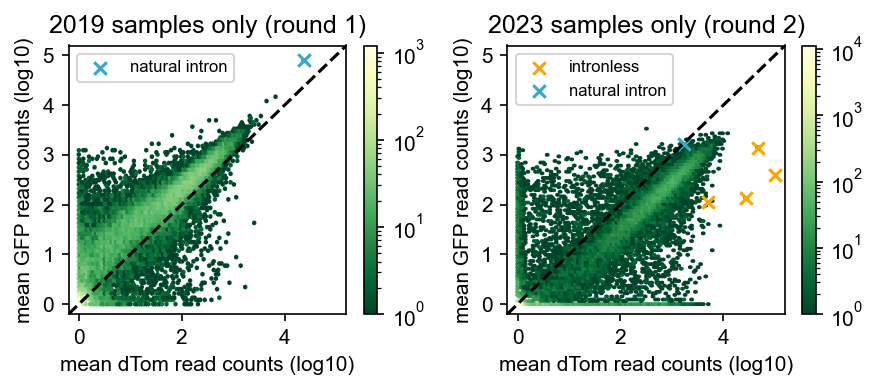

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.7))

hb1=ax1.hexbin(np.log10(1+dTom_counts_g[:,:5].mean(1)),
           np.log10(1+GFP_counts_g[:,:5].mean(1)), cmap='YlGn_r',
           bins='log')
ax1.set_title('2019 samples only (round 1)')
ax1.set_xlabel('mean dTom read counts (log10)')
ax1.set_ylabel('mean GFP read counts (log10)')
for msk, col, name in [(pos_ctrl_mask, nicecolors(3), 'natural intron')]:                
    ax1.scatter(np.log10(1+dTom_counts_g[:,:5].mean(1))[msk],
                np.log10(1+GFP_counts_g[:,:5].mean(1))[msk],
               marker='x', color=col, label=name)
ax1.legend(loc=2, fontsize=8)
cb1 = fig.colorbar(hb1, #label='density'
                  )

hb2=ax2.hexbin(np.log10(1+dTom_counts_g[:,5:10].mean(1)),
           np.log10(1+GFP_counts_g[:,5:10].mean(1)), cmap='YlGn_r',
           bins='log')
ax2.set_title('2023 samples only (round 2)')
ax2.set_xlabel('mean dTom read counts (log10)')
ax2.set_ylabel('mean GFP read counts (log10)')
for msk, col, name in [(intless_mask, 'orange', 'intronless'), (pos_ctrl_mask, nicecolors(3), 'natural intron')]:                
    ax2.scatter(np.log10(1+dTom_counts_g[:,5:10].mean(1))[msk],
                np.log10(1+GFP_counts_g[:,5:10].mean(1))[msk],
               marker='x', color=col, label=name)
ax2.legend(loc=2, fontsize=8)

cb2 = fig.colorbar(hb2, #label='density'
                 )

# Get the limits from ax1
xlims = (-0.2,5.2)
ylims = xlims

# Set the limits of ax2 to match ax1
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

ax1.plot((xlims[0],xlims[1]),(ylims[0],ylims[1]), linestyle='--', color='k')
ax2.plot((xlims[0],xlims[1]),(ylims[0],ylims[1]), linestyle='--', color='k')

plt.tight_layout()
plt.show()

I will apply one more filter before exporting the table, which is to only use barcodes of introns that are present (presence defined as at least 10 GFP reads AND at least 10 dTom reads) in 4 or more samples. this gives me ~11000 barcodes that I can evaluate, which is just under 50% of the trustworthy barcodes I could be using, but I believe it is worth it to be more confident about each of these.

In [27]:
read_min = 10
min_sample_num = 3
inc_idx = ((dTom_counts_g>=read_min)&(GFP_counts_g+unspliced_counts_g>=read_min)).sum(1)>=min_sample_num
print(f'{np.sum(inc_idx)} introns present in any {min_sample_num} replicates')

round1_mask = ((dTom_counts_g[:,:5]>=read_min)&(GFP_counts_g[:,:5]+unspliced_counts_g[:,:5]>=read_min)).sum(1)>=1
round2_mask = ((dTom_counts_g[:,5:]>=read_min)&(GFP_counts_g[:,5:]+unspliced_counts_g[:,5:]>=read_min)).sum(1)>=1
shared_mask = round1_mask&round2_mask

print(f'{np.sum(round2_mask)} introns present in run 2')
print(f'{np.sum(shared_mask)} introns present in at least one sample from both runs')
print(f'{np.sum(inc_idx&round2_mask)} introns present in 4 reps + at least one sample of round 2')

19346 introns present in any 3 replicates
14146 introns present in run 2
8473 introns present in at least one sample from both runs
10087 introns present in 4 reps + at least one sample of round 2


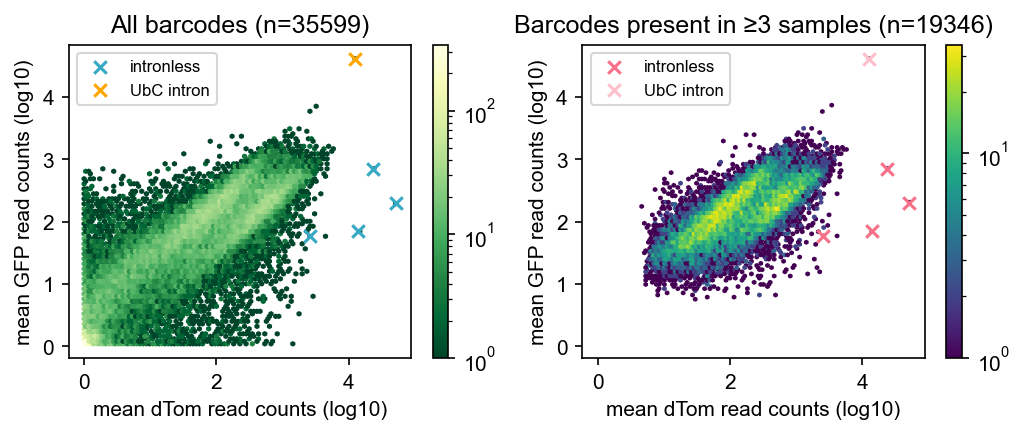

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

hb1 = ax1.hexbin(np.log10(1+dTom_counts_g.mean(1)),
           np.log10(1+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1)), cmap='YlGn_r',
           bins='log')
ax1.set_title(f'All barcodes (n={len(readcounts_g)})')
ax1.set_xlabel('mean dTom read counts (log10)')
ax1.set_ylabel('mean GFP read counts (log10)')

for msk, col, name in [(intless_mask, nicecolors(3), 'intronless'), 
                       (pos_ctrl_mask, 'orange', 'UbC intron')]:                
    
    ax1.scatter(np.log10(1+dTom_counts_g.mean(1))[msk],
                np.log10(1+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1))[msk],
               marker='x', color=col, label=name)
ax1.legend(loc=2, fontsize=8)
cb1 = fig.colorbar(hb1, #label='density'
                 )

hb2 = ax2.hexbin(np.log10(1+dTom_counts_g.mean(1)[inc_idx]),
           np.log10((1+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1))[inc_idx]),
           bins='log')
ax2.set_title(f'Barcodes present in ≥3 samples (n={len(dTom_counts_g.mean(1)[inc_idx])})')
ax2.set_xlabel('mean dTom read counts (log10)')
ax2.set_ylabel('mean GFP read counts (log10)')

for msk, col, name in [(intless_mask, nicecolors(0), 'intronless'), (pos_ctrl_mask, 'pink', 'UbC intron')]:                
    ax2.scatter(np.log10(1+dTom_counts_g.mean(1))[inc_idx&msk],
                np.log10(1+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1))[inc_idx&msk],
               marker='x', color=col, label=name)
ax2.legend(loc=2, fontsize=8)
cb2 = fig.colorbar(hb2, #label='density'
                 )

# Get the limits from ax1
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

# Set the limits of ax2 to match ax1
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)

plt.tight_layout()
plt.show()

In [29]:
xlims

(-0.23559715406086676, 4.947540131615456)

In [30]:
ylims

(-0.1869156319323457, 4.835867344060212)

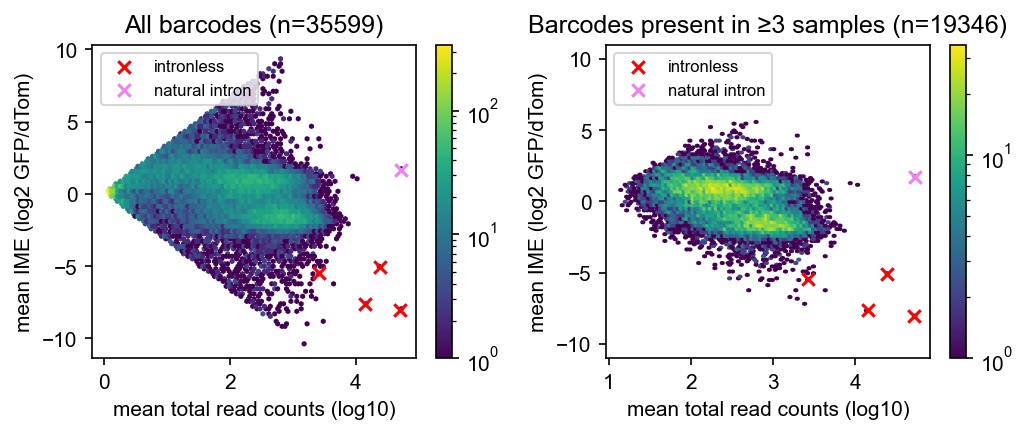

In [31]:
total_rc = np.log10((1+dTom_counts_g.mean(1)+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1)))
raw_IME_ratio = (1+GFP_counts_g.mean(1)+unspliced_counts_g.mean(1))/(1+dTom_counts_g.mean(1))
raw_IME = np.log2(raw_IME_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

hb1 = ax1.hexbin(total_rc,raw_IME,bins='log')
ax1.set_title(f'All barcodes (n={len(readcounts_g)})')
ax1.set_xlabel('mean total read counts (log10)')
ax1.set_ylabel('mean IME (log2 GFP/dTom)')

for msk, col, name in [(intless_mask, 'red', 'intronless'), (pos_ctrl_mask, 'violet', 'natural intron')]:
    ax1.scatter(total_rc[msk],
                raw_IME[msk],
                marker='x', color=col, label=name)
ax1.legend(loc=2, fontsize=8)
cb1 = fig.colorbar(hb1, #label='density'
                 )

hb2 = ax2.hexbin(total_rc[inc_idx],raw_IME[inc_idx],bins='log')
#hb2 = ax2.hexbin(total_rc,raw_IME,
           
#ax2.set_title(f'Barcodes present in ≥4 samples &\nat least 1 sample from round 2 (n={len(dTom_counts_g.mean(1)[inc_idx&round2_mask])})')
ax2.set_title(f'Barcodes present in ≥3 samples (n={len(dTom_counts_g.mean(1)[inc_idx])})')
#ax2.set_title(f'All detected & trustworthy barcodes (n={RIL_good_df_nonzero.shape[0]})')
ax2.set_xlabel('mean total read counts (log10)')
ax2.set_ylabel('mean IME (log2 GFP/dTom)')
ax2.set_ylim(-11,11)

for msk, col, name in [(intless_mask, 'red', 'intronless'), (pos_ctrl_mask, 'violet', 'natural intron')]:                
    ax2.scatter(total_rc[inc_idx&msk],raw_IME[inc_idx&msk], marker='x', color=col, label=name)
ax2.legend(loc=2, fontsize=8)
cb2 = fig.colorbar(hb2, #label='density'
                 )

plt.tight_layout()
plt.show()

In [32]:
# export data and exp info for DESeq2+Ashr
RIL_good_df_with_sample_filter = RIL_good_df_nonzero[inc_idx]

experiment_info={'colname':RIL_good_df_with_sample_filter.iloc[:,:num_reps*2].columns.values,
            'reporter':np.array(['GFP']*num_reps+['dTOM']*num_reps),
            'replicate':np.tile(np.arange(num_reps)+1,2),
            'run':np.tile(np.array([1]*5+[2]*5),2),
            'transfection':np.tile(np.array([1,2,3,4,5]+[1,1,2,2,3]),2)}

exp_info=pd.DataFrame.from_dict(experiment_info)

# summing spliced + unspliced GFP reads
GFP_sum = RIL_good_df_with_sample_filter.iloc[:,:num_reps*2].copy()

for i in samples:
    GFP_sum[f'GFP_{i}'] = RIL_good_df_with_sample_filter[f'GFP_{i}'] + RIL_good_df_with_sample_filter[f'unspliced_{i}']

GFP_sum.to_csv(outpath+'/data/integrated_GFP_dTom_counts.csv')
exp_info.to_csv(outpath+'/data/integrated_experiment_info.csv')

# export table with unspliced GFP readcounts as well for further analysis
RIL_good_df_with_sample_filter.to_csv(outpath+'/data/integrated_GFP_dTom_counts_with_unspliced.csv')

In [33]:
GFP_sum.loc[intronless_barcodes+[UbC_bc]]

,GFP_1,GFP_2,GFP_3,GFP_4,GFP_5,GFP_6,GFP_7,GFP_8,GFP_9,GFP_10,dTom_1,dTom_2,dTom_3,dTom_4,dTom_5,dTom_6,dTom_7,dTom_8,dTom_9,dTom_10
ACTATCTAACCAAACACA,0,0,0,0,0,33,9,81,122,323,0,0,0,0,0,3523,3656,5094,4683,8766
ACTCCTTCAATCCCATCA,0,0,0,0,0,75,91,85,113,332,0,0,0,0,0,23691,24352,33457,23002,36859
CATAACTTAATTATTTTA,4,1,2,0,0,488,554,2878,2964,70,3,1,0,0,0,43844,35186,52986,36287,67768
TACATTATCTCTTCATAC,0,0,0,0,0,306,215,903,132,408,0,0,0,0,0,100727,89792,120955,81666,122011
ATACCATAACTACCCACT,93184,209922,56155,16789,20846,3405,3828,178,219,561,15116,37236,53529,5575,6177,2132,2989,963,1001,1559
